<a href="https://colab.research.google.com/github/smh997/Audiobook-Customer-Segmentation-and-Purchase-Prediction/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Read dataset
dataset = pd.read_csv('Dataset.csv')

# Modifying columns
dataset = dataset.rename(columns={"Book_length(mins)_overall": "Book_length(mins)_avg",
                                  'Book_length(mins)_avg': 'Book_length(mins)_overall',
                                  'Price_overall': 'Price_avg', 'Price_avg': 'Price_overall'})

# Correcting Review Column
dataset.loc[dataset['Review10/10'].isnull() == False, 'Review'] = 1

# Output: Cleaned Dataset
dataset.to_csv('Cleaned_Dataset.csv')


In [36]:
import pandas as pd


def segmentation(dataset: pd.DataFrame, rfm: list, d: int):
    """
    Separate RFM Segmentation function
    :param dataset: given dataset
    :param rfm: a list of three column name R, F, M
    :param d: number of delimiters to divide data based on each factor
    :return: dataset with new segment column
    """
    def segment_calculator(customer_data, delimiters, ds, factors):
        """
        Calculator of each customer segment based on factors
        :param customer_data: a row of data related to a customer
        :param delimiters: a dictionary of the length between each group based on each factor
        :param ds: given dataset
        :param factors: a list of three column name R, F, M
        :return: segment_id of the customer
        """
        segment_id = 0
        i = 9
        for factor in factors:
            j = 1
            min_value = ds[factor].min()
            while j != 3 and min_value + j * delimiters[factor] <= customer_data[factor]:
                j += 1
            segment_id += (j - 1) * i
            i //= 3
        segment_id += 1
        return segment_id

    # Calculating delimiters to make
    factor_group_delimiters = {}
    for factor in rfm:
        factor_range = dataset[factor].max() - dataset[factor].min()
        factor_group_delimiters[factor] = factor_range / d

    # Adding segmentation results to dataset
    dataset['Separate_Approch_Segment'] = dataset.apply(
        lambda row: segment_calculator(row, factor_group_delimiters, dataset, rfm), axis=1)

    return dataset


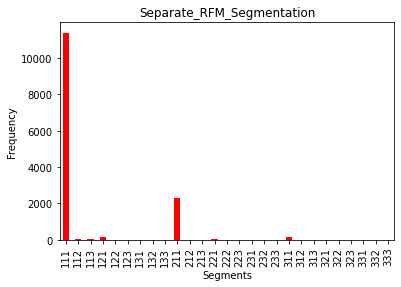

In [37]:

# Reading dataset
dataset = pd.read_csv('Cleaned_Dataset.csv')

# Creating a Column for Frequency
dataset['Number_of_Books'] = dataset.apply(
    lambda row: int(round(row['Book_length(mins)_overall'] / row['Book_length(mins)_avg'])), axis=1)

# Setting RFM factors
R = 'Last_Visited_mins_Purchase_date'
F = 'Number_of_Books'
M = 'Price_overall'

# Performing RFM Separate Segmentation
dataset = segmentation(dataset, [R, F, M], 3)

# Calculating size of each segment
data = dataset.groupby('Separate_Approch_Segment')['id'].nunique()

# Adding empty segments
for i in range(1, 28):
  if i not in data.index:
    data = data.append(pd.Series([0,], index=[i,]))

# Changing indices to 3 character format
new_index = []
for i in range(1, 4):
  for j in range(1, 4):
    for k in range(1, 4):
      new_index.append(str(i) + str(j) + str(k))
data = data.sort_index()
data.index = new_index

# Plotting segments using bar plot
_ = data.plot.bar(color='red', xlabel='Segments', ylabel='Frequency', title='Separate_RFM_Segmentation')


In [38]:
import operator

def segmentation(dataset: pd.DataFrame, rfm: list, d: int):
    """
    Sort RFM Segmentation function
    :param dataset: given dataset
    :param rfm: a list of three column name R, F, M
    :param d: number of delimiters to divide data based on each factor
    :return: dataset with new segment column
    """
    datalists = [dataset.values.tolist()]
    for factor in rfm:
        new_datalists = []
        for datalist in datalists:
            datalist.sort(key=operator.itemgetter(dataset.columns.get_loc(factor)))
            size = len(datalist)
            low_index = 0
            rem = size % d
            step = size / d
            for i in range(d):
                up_index = low_index + int(step) + (1 if rem > 0 else 0)
                new_datalists.append(datalist[low_index: up_index])
                rem -= 1
                low_index = up_index
        datalists = new_datalists

    # Determining customer segments
    customer_segment = dict()
    id_index = dataset.columns.get_loc('id')
    for segment_id in range(d**3):
        for customer in datalists[segment_id]:
            customer_segment[customer[id_index]] = segment_id + 1

    # Adding segmentation results to dataset
    dataset['Sort_Approch_Segment'] = dataset.apply(lambda row: customer_segment[row['id']], axis=1)

    return dataset



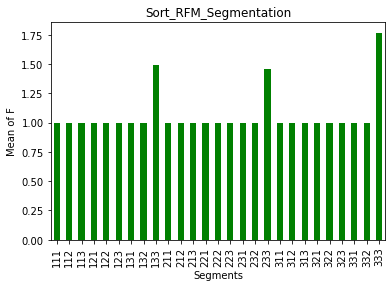

In [39]:
# Performing RFM Sort Segmentation
dataset = segmentation(dataset, [R, F, M], 3)

# Calculating F Mean for each segment
data1 = dataset.groupby("Sort_Approch_Segment")[F].mean()

# Changing indices to 3 character format
data1.index = new_index

# Plotting segments using bar plot
_ = data1.plot.bar(color='green', xlabel='Segments', ylabel='Mean of F', title='Sort_RFM_Segmentation')


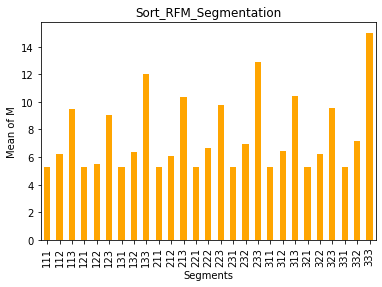

In [40]:
# Calculating M Mean for each segment
data2 = dataset.groupby("Sort_Approch_Segment")[M].mean() 

# Changing indices to 3 character format
data2.index = new_index

# Plotting segments using bar plot
_ = data2.plot.bar(color='orange', xlabel='Segments', ylabel='Mean of M', title='Sort_RFM_Segmentation')

dataset.to_csv('RFM.csv', index=False)

id                                     0
Book_length(mins)_avg                  0
Book_length(mins)_overall              0
Price_avg                              0
Price_overall                          0
Review                                 0
Review10/10                        11616
Completion                             0
Minutes_listened                       0
Support_Request                        0
Last_Visited_mins_Purchase_date        0
Target                                 0
dtype: int64
0        10.000000
1         8.908829
2         8.908829
3         8.908829
4         8.908829
           ...    
14079     9.000000
14080     6.000000
14081     8.908829
14082     8.000000
14083     8.908829
Name: Review10/10, Length: 14084, dtype: float64
id                                 0
Book_length(mins)_avg              0
Book_length(mins)_overall          0
Price_avg                          0
Price_overall                      0
Review                             0
Review10/10    

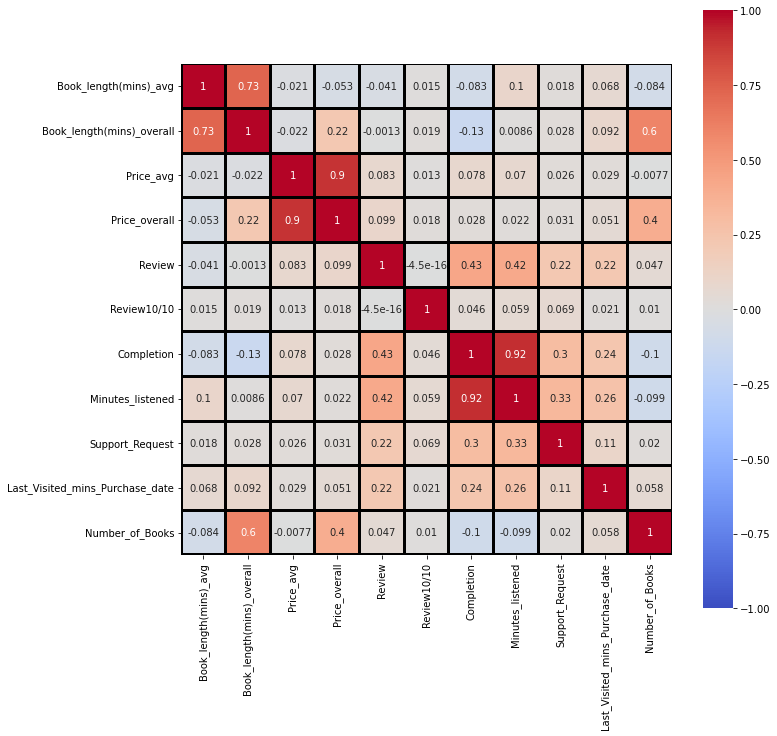

Index(['Price_avg', 'Review10/10', 'Completion', 'Support_Request',
       'Last_Visited_mins_Purchase_date', 'Number_of_Books'],
      dtype='object')


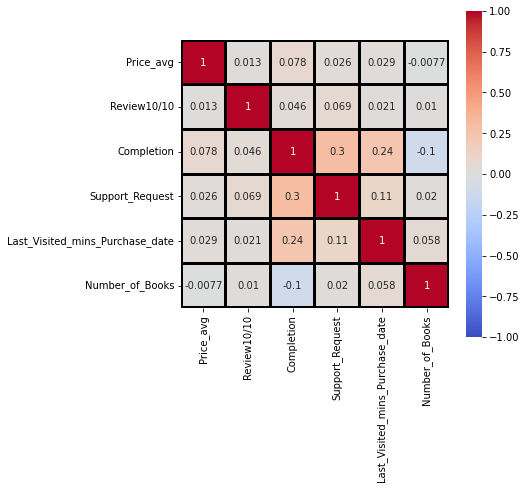

Normalized:
              0         1     2         3         4         5
0      0.124882  1.000000  0.99  0.166667  0.198276  0.000000
1      0.011568  0.878759  0.00  0.000000  0.000000  0.000000
2      0.011568  0.878759  0.00  0.000000  0.836207  0.000000
3      0.016525  0.878759  0.42  0.033333  0.278017  0.000000
4      0.011568  0.878759  0.22  0.000000  0.778017  0.000000
...         ...       ...   ...       ...       ...       ...
14079  0.011568  0.888889  0.61  0.000000  0.008621  0.000000
14080  0.021168  0.555556  0.29  0.000000  0.062500  0.000000
14081  0.017941  0.878759  0.00  0.000000  0.000000  0.000000
14082  0.011568  0.777778  0.38  0.000000  0.193966  0.000000
14083  0.011568  0.878759  0.00  0.000000  0.000000  0.166667

[14084 rows x 6 columns]


In [41]:
import pandas as pd
import numpy as np
import seaborn as sb
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

# Reading dataset
dataset = pd.read_csv('Cleaned_Dataset.csv', index_col=0)

# Checking lost values
print(dataset.isnull().sum())

# Fill lost values
dataset['Review10/10'].fillna(dataset['Review10/10'].mean(), inplace=True)
print(dataset['Review10/10'])

# Checking lost values again
print(dataset.isnull().sum())

# Saving a copy of dataset
unpreprocessed_dataset = dataset.copy()

# Dropping unnecessary data columns
dataset = dataset.drop(["id", "Target"], axis=1)

# Adding Number_of_Books column
dataset['Number_of_Books'] = dataset.apply(
    lambda row: int(round(row['Book_length(mins)_overall'] / row['Book_length(mins)_avg'])), axis=1)

# Removing Outliers

# from scipy import stats
# z_scores = stats.zscore(dataset)
# abs_z_scores = np.abs(z_scores)
# filtered_entries = (abs_z_scores < 3).all(axis=1)
# dataset = dataset[filtered_entries]


# PlottingCorrelation Matrix
correlation = dataset.corr()
plt.figure(figsize=(11, 11))
sb.heatmap(data=correlation, square=True, annot=True, vmin=-1, vmax=1, center=0,
           cmap='coolwarm', annot_kws={"size": 10}, linewidths=2, linecolor='black', )
plt.show()

# Dropping some additional columns and redraw matrix
dataset.drop(['Book_length(mins)_overall', 'Book_length(mins)_avg', 'Price_overall', 'Review', 'Minutes_listened'],
             axis=1, inplace=True)
print(dataset.columns)

# PlottingCorrelation Matrix again
correlation = dataset.corr()
plt.figure(figsize=(6, 6))
sb.heatmap(data=correlation, square=True, annot=True, vmin=-1, vmax=1, center=0,
           cmap='coolwarm', annot_kws={"size": 10}, linewidths=2, linecolor='black',)
plt.show()

# Normalization
x = dataset.values
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
dataset = pd.DataFrame(x_scaled)
print('Normalized:')
print(dataset)

Distortion of each k:
1 : 0.2653515610302855
2 : 0.1984695149985284
3 : 0.13740891800540136
4 : 0.11859331319002532
5 : 0.110242892298019
6 : 0.09936370035515438
7 : 0.09721702768892666
8 : 0.09410297566833783
9 : 0.08802933378579775
10 : 0.0835505844096057


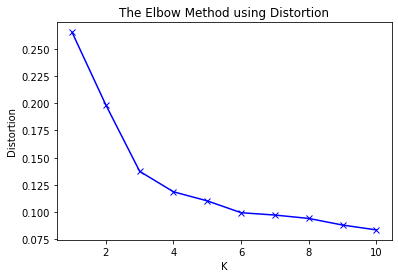

Inertia of each k:
1 : 1467.7991048860545
2 : 803.4688927570587
3 : 463.61500426971077
4 : 366.3762160466808
5 : 318.2737267616217
6 : 280.2095535454188
7 : 255.30042759765743
8 : 234.93353594785935
9 : 211.9717196040502
10 : 190.3332082200888


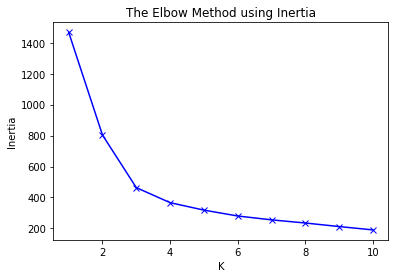

In [42]:
# Plotting Elbow Method

distortions = []
inertias = []
distortion_mapping = {}
inertia_mapping = {}
K = range(1, 11)

for k in K:
    # Building and fitting the model for each k
    X = dataset.values
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)

    # Calculating distortion and inertia
    distortion = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]
    distortions.append(distortion)
    inertias.append(kmeanModel.inertia_)
    distortion_mapping[k] = distortion
    inertia_mapping[k] = kmeanModel.inertia_

# Distortion of each k
print('Distortion of each k:')
for k, d in distortion_mapping.items():
    print(f'{k} : {d}')

# Distortion Elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

# Inertia of each k
print('Inertia of each k:')
for k, i in inertia_mapping.items():
    print(f'{k} : {i}')

# Inertia Elbow
plt.plot(K, inertias, 'bx-')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

Silhouette Score: 0.6557936852372658
Inertia: 325.6050422999722


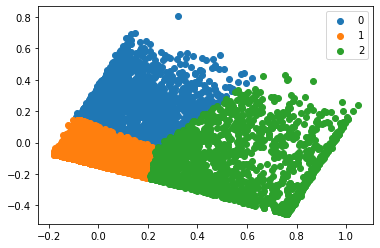

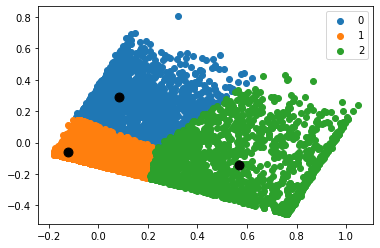

In [43]:
# Clustering

# Initializing and using PCA
pca = PCA(2)
df = pca.fit_transform(dataset)

# Perform K-Means with suitable k = 3
kmeans = KMeans(n_clusters=3)
kmeans_model = kmeans.fit(df)
label = kmeans_model.labels_

# Calculating Silhouette Score and Inertia for analyzing our KMeans performance
print('Silhouette Score:', metrics.silhouette_score(df, label, metric='euclidean'))
print('Inertia:', kmeans.inertia_)

# Getting unique labels for PCA
u_labels = np.unique(label)

# Plotting the results (PCA):
for i in u_labels:
    plt.scatter(df[label == i, 0], df[label == i, 1], label=i)
plt.legend()
plt.show()

# Getting the Centroids for PCA
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)

# plotting the Centroids (PCA):
for i in u_labels:
    plt.scatter(df[label == i, 0], df[label == i, 1], label=i)
plt.scatter(centroids[:, 0], centroids[:, 1], s=80, color='black')
plt.legend()
plt.show()


In [44]:
import random

# Balancing

np_dataset = unpreprocessed_dataset.values
unpreprocessed_data = np_dataset[:, 1:-1]
targets = np_dataset[:, -1]
size = targets.shape[0]
one_cnt = int(np.sum(targets))
zero_cnt = size - one_cnt
zero_indices = []
remove_indices = []

# Removing additional zero labeled data in random
for i in range(size):
    if targets[i] == 0:
        zero_indices.append(i)
for i in range((zero_cnt - one_cnt)):
    r_index = random.randint(0, zero_cnt-i-1)
    remove_indices.append(zero_indices[r_index])
    zero_indices.pop(r_index)
unpreprocessed_data = np.delete(unpreprocessed_data, remove_indices, axis=0)
preprocessed_data = np.delete(dataset.values, remove_indices, axis=0)
targets = np.delete(targets, remove_indices, axis=0)

# unpreprocessed_data = np.delete(unpreprocessed_data, zero_indices[zero_cnt-(zero_cnt - one_cnt):], axis=0)
# preprocessed_data = np.delete(dataset.values, zero_indices[zero_cnt-(zero_cnt - one_cnt):], axis=0)
# targets = np.delete(targets, zero_indices[zero_cnt-(zero_cnt - one_cnt):], axis=0)
# unpreprocessed_data = np.delete(unpreprocessed_data, zero_indices[:(zero_cnt - one_cnt)], axis=0)
# preprocessed_data = np.delete(dataset.values, zero_indices[:(zero_cnt - one_cnt)], axis=0)
# targets = np.delete(targets, zero_indices[:(zero_cnt - one_cnt)], axis=0)


# Shuffling
shuffled_indices = np.arange(preprocessed_data.shape[0])
np.random.shuffle(shuffled_indices)
shuffled_data = preprocessed_data[shuffled_indices]
shuffled_targets = targets[shuffled_indices]


Random Forest Cross Validation: 0.8176186890783661
XGB Cross Validation: 0.8121945015363952
SVM Cross Validation: 0.7524623023544494
*** Random Forest Classification Report ***

Confusion Matrix:
 [[576 110]
 [140 517]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.84      0.82       686
         1.0       0.82      0.79      0.81       657

    accuracy                           0.81      1343
   macro avg       0.81      0.81      0.81      1343
weighted avg       0.81      0.81      0.81      1343


Accuracy:
 0.813849590469099

*** XGB Classification Report ***

Confusion Matrix:
 [[585 101]
 [158 499]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.85      0.82       686
         1.0       0.83      0.76      0.79       657

    accuracy                           0.81      1343
   macro avg       0.81      0.81      0.81      1343
weighted avg       0.81

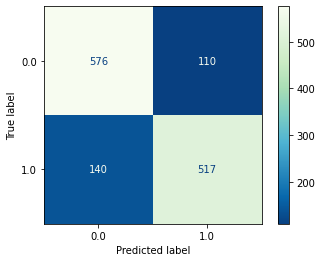


XGB Confusion Matrix:


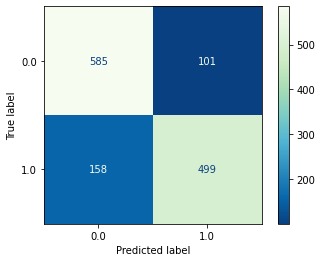


SVM Confusion Matrix:


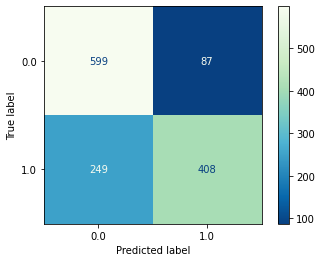

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix
import seaborn as sns
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Classification

df = pd.DataFrame(shuffled_data)
target_df = pd.DataFrame(shuffled_targets)
X_train, X_test, y_train, y_test = train_test_split(df, target_df, test_size=0.3, random_state=0)

# Random Forest Classifier
rf_clf = RandomForestClassifier(max_depth=2, random_state=0, n_jobs=-1)
# 10-Fold Cross validation
print('Random Forest Cross Validation:', np.mean(cross_val_score(rf_clf, X_train, y_train, cv=10)))
rf_clf.fit(X_train, y_train)
predict = rf_clf.predict(X_test)

# Extreme Gradient Boost Classifier
xgb_clf = XGBClassifier(learning_rate=0.5, n_estimators=150, base_score=0.3)
# 10-Fold Cross validation
print('XGB Cross Validation:', np.mean(cross_val_score(xgb_clf, X_train, y_train, cv=10)))
xgb_clf.fit(X_train, y_train)
predict2 = xgb_clf.predict(X_test)

# Support Vector Machine Classifier
svm_clf = SVC()
# 10-Fold Cross validation
print('SVM Cross Validation:', np.mean(cross_val_score(svm_clf, X_train, y_train, cv=10)))
svm_clf.fit(X_train, y_train)
predict3 = svm_clf.predict(X_test)


def classification_data_report(name, y_test_internal, pred_internal):
    """
    A function for reporting some analytical data about classification's performance
    :param name: classification model name
    :param y_test_internal: labels of test data
    :param pred_internal: predicted labels for test data
    :return: None
    """
    print('*** {} Classification Report ***'.format(name), end='\n\n')
    print('Confusion Matrix:\n', confusion_matrix(y_test_internal, pred_internal), end='\n\n')
    print('Classification Report:\n', classification_report(y_test_internal, pred_internal), end='\n\n')
    print('Accuracy:\n', accuracy_score(y_test_internal, pred_internal), end='\n\n')


# Accuracy, F-measure and other data about classification
classification_data_report("Random Forest", y_test, predict)
classification_data_report("XGB", y_test, predict2)
classification_data_report("SVM", y_test, predict3)


# Confusion Matrix

print('Random Forest Confusion Matrix:')
plot_confusion_matrix(rf_clf, X_test, y_test, cmap="GnBu_r")
plt.show()
print()

print('XGB Confusion Matrix:')
plot_confusion_matrix(xgb_clf, X_test, y_test, cmap="GnBu_r")
plt.show()
print()

print('SVM Confusion Matrix:')
plot_confusion_matrix(svm_clf, X_test, y_test, cmap="GnBu_r")
plt.show()
print()